# PreTrain

In [1]:
from model.sswae_dev2_1 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 6

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [ ]:
epoch = 20
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.511
[2] loss: 0.401
[3] loss: 0.161
[4] loss: 0.057
[5] loss: 0.029
[6] loss: 0.021
[7] loss: 0.013
[8] loss: 0.011
[9] loss: 0.010
[10] loss: 0.006
[11] loss: 0.008
[12] loss: 0.006
[13] loss: 0.005
[14] loss: 0.005
[15] loss: 0.004
[16] loss: 0.004


In [ ]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

In [ ]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [ ]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [ ]:
ys = np.zeros((10, y_dim))
cs = np.zeros(10)
covs = np.zeros((10, y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [ ]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

In [ ]:
f1 = nn.Linear(10, y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/mu_{y_dim}.pt')

In [ ]:
w2 = torch.tensor((covs.T / (cs - 1)).T)

In [ ]:
for i in range(10):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [ ]:
f2 = nn.ConvTranspose2d(10, 1, y_dim, bias=False)
f2.weight.data = w2.view(10,1,y_dim,y_dim)
torch.save(f2.state_dict(), f'./result/cov_{y_dim}.pt')

# Train

In [3]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_1_2.cfg')

['./config/sswae_dev2_1_2.cfg']

In [4]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}.pt'))

mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 6
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 6
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1280] [01/80]  loss: 2.359189e-01  D: 7.542557e-01  D2: 3.989247e-02  D3: 2.859773e-03
test loss: 1.997388e-01  D: 6.588554e-01  D2: 1.302189e-02  D3: 1.692719e-02


[default |INFO|model.py:1280] [02/80]  loss: 1.755386e-01  D: 6.768849e-01  D2: 6.880671e-03  D3: 8.387116e-03
test loss: 1.519245e-01  D: 7.016700e-01  D2: -2.787113e-04  D3: 7.606452e-03


[default |INFO|model.py:1280] [03/80]  loss: 1.722434e-01  D: 8.121184e-01  D2: -8.406703e-04  D3: 1.360791e-02
test loss: 1.696807e-01  D: 7.093191e-01  D2: -1.240950e-03  D3: 1.659852e-02


[default |INFO|model.py:1280] [04/80]  loss: 1.427381e-01  D: 6.731309e-01  D2: -2.296152e-03  D3: 9.747587e-03
test loss: 1.140179e-01  D: 6.899204e-01  D2: -2.834129e-03  D3: 4.857655e-03


[default |INFO|model.py:1280] [05/80]  loss: 1.045042e-01  D: 6.939537e-01  D2: -3.449777e-03  D3: 4.305484e-03
test loss: 9.579287e-02  D: 6.968482e-01  D2: -4.588261e-03  D3: 3.685930e-03


[default |INFO|model.py:1280] [06/80]  loss: 9.000608e-02  D: 6.967430e-01  D2: -4.934295e-03  D3: 3.737134e-03
test loss: 8.199362e-02  D: 6.964071e-01  D2: -5.448380e-03  D3: 5.827017e-03


[default |INFO|model.py:1280] [07/80]  loss: 8.773688e-02  D: 6.990010e-01  D2: -5.181481e-03  D3: 9.371388e-03
test loss: 9.137838e-02  D: 7.219700e-01  D2: -4.263000e-03  D3: 1.256737e-02


[default |INFO|model.py:1280] [08/80]  loss: 9.557930e-02  D: 6.911369e-01  D2: -4.711094e-03  D3: 1.531738e-02
test loss: 8.515736e-02  D: 7.248752e-01  D2: -5.130358e-03  D3: 1.346038e-02


[default |INFO|model.py:1280] [09/80]  loss: 8.263162e-02  D: 6.961464e-01  D2: -5.166151e-03  D3: 1.443053e-02
test loss: 7.810028e-02  D: 6.937762e-01  D2: -6.087151e-03  D3: 1.728336e-02


[default |INFO|model.py:1280] [10/80]  loss: 7.681592e-02  D: 6.934682e-01  D2: -5.259242e-03  D3: 1.531478e-02
test loss: 7.387991e-02  D: 6.865844e-01  D2: -4.984179e-03  D3: 1.480090e-02


[default |INFO|model.py:1280] [11/80]  loss: 7.150506e-02  D: 6.929280e-01  D2: -5.703729e-03  D3: 1.515785e-02
test loss: 6.831940e-02  D: 6.826111e-01  D2: -4.197769e-03  D3: 1.644294e-02


[default |INFO|model.py:1280] [12/80]  loss: 7.289613e-02  D: 6.901014e-01  D2: -5.735881e-03  D3: 1.399521e-02
test loss: 6.810921e-02  D: 6.932485e-01  D2: -6.463499e-03  D3: 1.098240e-02


[default |INFO|model.py:1280] [13/80]  loss: 7.404863e-02  D: 6.955168e-01  D2: -5.830266e-03  D3: 1.269890e-02
test loss: 6.860936e-02  D: 6.916236e-01  D2: -6.283226e-03  D3: 1.028551e-02


[default |INFO|model.py:1280] [14/80]  loss: 7.373306e-02  D: 6.947666e-01  D2: -6.574078e-03  D3: 1.341246e-02
test loss: 6.953648e-02  D: 7.308472e-01  D2: -6.756802e-03  D3: 1.252714e-02


[default |INFO|model.py:1280] [15/80]  loss: 7.624879e-02  D: 6.942645e-01  D2: -6.302536e-03  D3: 1.278949e-02
test loss: 6.799620e-02  D: 6.794173e-01  D2: -6.337481e-03  D3: 1.383273e-02


[default |INFO|model.py:1280] [16/80]  loss: 7.501910e-02  D: 6.963013e-01  D2: -6.478335e-03  D3: 1.207690e-02
test loss: 6.862580e-02  D: 7.006514e-01  D2: -6.577263e-03  D3: 1.349876e-02


[default |INFO|model.py:1280] [17/80]  loss: 7.994052e-02  D: 6.977820e-01  D2: -6.679417e-03  D3: 1.124016e-02
test loss: 7.950660e-02  D: 6.551357e-01  D2: -6.805964e-03  D3: 1.302029e-02


[default |INFO|model.py:1280] [18/80]  loss: 8.129553e-02  D: 6.948314e-01  D2: -6.916733e-03  D3: 1.124317e-02
test loss: 8.323927e-02  D: 6.849563e-01  D2: -7.244139e-03  D3: 1.182320e-02


[default |INFO|model.py:1280] [19/80]  loss: 7.332246e-02  D: 6.937176e-01  D2: -6.815825e-03  D3: 1.330871e-02
test loss: 7.165253e-02  D: 6.822055e-01  D2: -6.987467e-03  D3: 1.616685e-02


[default |INFO|model.py:1280] [20/80]  loss: 7.600662e-02  D: 6.933767e-01  D2: -6.912290e-03  D3: 1.210080e-02
test loss: 7.028216e-02  D: 6.751906e-01  D2: -7.091265e-03  D3: 1.651947e-02


[default |INFO|model.py:1280] [21/80]  loss: 7.314540e-02  D: 6.971632e-01  D2: -7.068081e-03  D3: 1.207730e-02
test loss: 7.379386e-02  D: 6.982022e-01  D2: -7.036114e-03  D3: 1.292596e-02


[default |INFO|model.py:1280] [22/80]  loss: 6.962541e-02  D: 6.930834e-01  D2: -7.276211e-03  D3: 1.304434e-02
test loss: 6.992172e-02  D: 6.738424e-01  D2: -7.350588e-03  D3: 1.451095e-02


[default |INFO|model.py:1280] [23/80]  loss: 6.845016e-02  D: 6.932271e-01  D2: -7.308900e-03  D3: 1.303087e-02
test loss: 7.080563e-02  D: 6.885780e-01  D2: -7.236948e-03  D3: 1.374811e-02


[default |INFO|model.py:1280] [24/80]  loss: 6.872496e-02  D: 6.956078e-01  D2: -7.414886e-03  D3: 1.269465e-02
test loss: 7.231761e-02  D: 7.058000e-01  D2: -7.973433e-03  D3: 1.297920e-02


[default |INFO|model.py:1280] [25/80]  loss: 6.837050e-02  D: 6.924052e-01  D2: -7.499372e-03  D3: 1.310788e-02
test loss: 6.156389e-02  D: 6.740873e-01  D2: -7.641087e-03  D3: 1.461066e-02


[default |INFO|model.py:1280] [26/80]  loss: 6.606698e-02  D: 6.962624e-01  D2: -7.654729e-03  D3: 1.305364e-02
test loss: 6.543057e-02  D: 6.986260e-01  D2: -7.500620e-03  D3: 1.041238e-02


[default |INFO|model.py:1280] [27/80]  loss: 6.138240e-02  D: 6.937395e-01  D2: -7.704854e-03  D3: 1.395945e-02
test loss: 6.486903e-02  D: 6.902169e-01  D2: -7.939882e-03  D3: 1.650602e-02


[default |INFO|model.py:1280] [28/80]  loss: 6.323802e-02  D: 6.939435e-01  D2: -7.660389e-03  D3: 1.347825e-02
test loss: 6.100992e-02  D: 6.969529e-01  D2: -7.491074e-03  D3: 1.319402e-02


[default |INFO|model.py:1280] [29/80]  loss: 6.390956e-02  D: 6.935788e-01  D2: -7.617601e-03  D3: 1.331706e-02
test loss: 6.769522e-02  D: 6.752045e-01  D2: -7.645903e-03  D3: 9.398680e-03


[default |INFO|model.py:1280] [30/80]  loss: 6.490691e-02  D: 6.955717e-01  D2: -7.850223e-03  D3: 1.273604e-02
test loss: 6.413138e-02  D: 7.098930e-01  D2: -7.041798e-03  D3: 1.293767e-02


[default |INFO|model.py:1280] [31/80]  loss: 6.455730e-02  D: 6.957082e-01  D2: -7.915853e-03  D3: 1.260362e-02
test loss: 7.115932e-02  D: 6.834012e-01  D2: -7.497416e-03  D3: 1.320554e-02


[default |INFO|model.py:1280] [32/80]  loss: 6.846249e-02  D: 6.930775e-01  D2: -7.865376e-03  D3: 1.132416e-02
test loss: 6.715328e-02  D: 6.896658e-01  D2: -7.693176e-03  D3: 1.424014e-02


[default |INFO|model.py:1280] [33/80]  loss: 6.528607e-02  D: 6.957024e-01  D2: -7.982435e-03  D3: 1.333343e-02
test loss: 6.214607e-02  D: 6.955891e-01  D2: -7.568779e-03  D3: 1.572965e-02


[default |INFO|model.py:1280] [34/80]  loss: 6.161788e-02  D: 6.929709e-01  D2: -8.023218e-03  D3: 1.402179e-02
test loss: 5.936063e-02  D: 6.754124e-01  D2: -7.662754e-03  D3: 1.487803e-02


[default |INFO|model.py:1280] [35/80]  loss: 6.197476e-02  D: 6.948685e-01  D2: -8.331134e-03  D3: 1.343348e-02
test loss: 6.351776e-02  D: 7.099306e-01  D2: -7.966061e-03  D3: 1.448388e-02


[default |INFO|model.py:1280] [36/80]  loss: 6.285139e-02  D: 6.934564e-01  D2: -8.173013e-03  D3: 1.350389e-02
test loss: 6.310857e-02  D: 6.804208e-01  D2: -8.428879e-03  D3: 1.422894e-02


[default |INFO|model.py:1280] [37/80]  loss: 6.187851e-02  D: 6.922393e-01  D2: -8.207674e-03  D3: 1.386943e-02
test loss: 6.181455e-02  D: 6.818045e-01  D2: -8.193588e-03  D3: 1.306243e-02


[default |INFO|model.py:1280] [38/80]  loss: 6.290962e-02  D: 6.950207e-01  D2: -8.184865e-03  D3: 1.291840e-02
test loss: 5.669501e-02  D: 7.008508e-01  D2: -8.588505e-03  D3: 1.501247e-02


[default |INFO|model.py:1280] [39/80]  loss: 6.118943e-02  D: 6.943102e-01  D2: -8.387186e-03  D3: 1.358464e-02
test loss: 6.484673e-02  D: 7.091027e-01  D2: -8.509588e-03  D3: 1.160270e-02


[default |INFO|model.py:1280] [40/80]  loss: 6.353045e-02  D: 6.963520e-01  D2: -8.587950e-03  D3: 1.293851e-02
test loss: 5.829092e-02  D: 7.024053e-01  D2: -8.589420e-03  D3: 1.203521e-02


[default |INFO|model.py:1280] [41/80]  loss: 5.896883e-02  D: 6.927794e-01  D2: -8.468952e-03  D3: 1.435544e-02
test loss: 5.841590e-02  D: 6.897549e-01  D2: -8.588409e-03  D3: 1.344267e-02


[default |INFO|model.py:1280] [42/80]  loss: 5.880585e-02  D: 6.939584e-01  D2: -8.617299e-03  D3: 1.366853e-02
test loss: 5.835630e-02  D: 6.856413e-01  D2: -8.806877e-03  D3: 1.464814e-02


[default |INFO|model.py:1280] [43/80]  loss: 5.573628e-02  D: 6.919959e-01  D2: -8.695963e-03  D3: 1.427026e-02
test loss: 5.631279e-02  D: 6.928690e-01  D2: -8.197374e-03  D3: 1.512134e-02


[default |INFO|model.py:1280] [44/80]  loss: 5.737681e-02  D: 6.921691e-01  D2: -8.573915e-03  D3: 1.367175e-02
test loss: 5.473866e-02  D: 6.975969e-01  D2: -8.865585e-03  D3: 1.186359e-02


[default |INFO|model.py:1280] [45/80]  loss: 5.682443e-02  D: 6.949070e-01  D2: -8.793658e-03  D3: 1.357315e-02
test loss: 5.969812e-02  D: 7.101758e-01  D2: -8.953485e-03  D3: 1.363163e-02


[default |INFO|model.py:1280] [46/80]  loss: 6.169894e-02  D: 6.950477e-01  D2: -8.893574e-03  D3: 1.280889e-02
test loss: 6.067508e-02  D: 6.911219e-01  D2: -8.866234e-03  D3: 1.302742e-02


[default |INFO|model.py:1280] [47/80]  loss: 5.881133e-02  D: 6.927798e-01  D2: -8.871147e-03  D3: 1.371431e-02
test loss: 5.631592e-02  D: 6.943773e-01  D2: -8.679848e-03  D3: 1.537117e-02


[default |INFO|model.py:1280] [48/80]  loss: 5.832369e-02  D: 6.927713e-01  D2: -9.003477e-03  D3: 1.342945e-02
test loss: 5.947628e-02  D: 6.883132e-01  D2: -9.144468e-03  D3: 1.173992e-02


[default |INFO|model.py:1280] [49/80]  loss: 5.970173e-02  D: 6.935930e-01  D2: -9.043846e-03  D3: 1.324208e-02
test loss: 6.262639e-02  D: 6.754141e-01  D2: -8.531084e-03  D3: 1.182095e-02


[default |INFO|model.py:1280] [50/80]  loss: 5.641438e-02  D: 6.947592e-01  D2: -9.020378e-03  D3: 1.389630e-02
test loss: 5.888302e-02  D: 6.886396e-01  D2: -8.743420e-03  D3: 1.495507e-02


[default |INFO|model.py:1280] [51/80]  loss: 5.487652e-02  D: 6.930269e-01  D2: -9.103545e-03  D3: 1.395517e-02
test loss: 5.470845e-02  D: 6.976790e-01  D2: -8.882132e-03  D3: 1.392546e-02


[default |INFO|model.py:1280] [52/80]  loss: 5.497082e-02  D: 6.933238e-01  D2: -9.123081e-03  D3: 1.347703e-02
test loss: 5.533345e-02  D: 6.726657e-01  D2: -9.299688e-03  D3: 1.318589e-02


[default |INFO|model.py:1280] [53/80]  loss: 5.354379e-02  D: 6.928278e-01  D2: -9.390395e-03  D3: 1.403672e-02
test loss: 5.509861e-02  D: 6.965096e-01  D2: -9.543839e-03  D3: 1.214131e-02


[default |INFO|model.py:1280] [54/80]  loss: 5.570643e-02  D: 6.951263e-01  D2: -9.341086e-03  D3: 1.332890e-02
test loss: 5.669415e-02  D: 6.810588e-01  D2: -9.533997e-03  D3: 1.266429e-02


[default |INFO|model.py:1280] [55/80]  loss: 5.628249e-02  D: 6.935041e-01  D2: -9.399563e-03  D3: 1.344497e-02
test loss: 5.979107e-02  D: 7.146266e-01  D2: -9.665947e-03  D3: 1.272778e-02


[default |INFO|model.py:1280] [56/80]  loss: 5.682125e-02  D: 6.940736e-01  D2: -9.382161e-03  D3: 1.314794e-02
test loss: 5.615889e-02  D: 7.052227e-01  D2: -9.722986e-03  D3: 1.381752e-02


[default |INFO|model.py:1280] [57/80]  loss: 5.698986e-02  D: 6.933734e-01  D2: -9.415496e-03  D3: 1.345853e-02
test loss: 5.489158e-02  D: 6.863649e-01  D2: -9.197187e-03  D3: 1.334855e-02


[default |INFO|model.py:1280] [58/80]  loss: 5.565529e-02  D: 6.938077e-01  D2: -9.568195e-03  D3: 1.305282e-02
test loss: 5.692848e-02  D: 7.048420e-01  D2: -9.446411e-03  D3: 1.214943e-02


[default |INFO|model.py:1280] [59/80]  loss: 5.782609e-02  D: 6.923594e-01  D2: -9.576534e-03  D3: 1.273129e-02
test loss: 6.035680e-02  D: 6.940546e-01  D2: -9.531279e-03  D3: 1.296998e-02


[default |INFO|model.py:1280] [60/80]  loss: 5.662734e-02  D: 6.937700e-01  D2: -9.564509e-03  D3: 1.344398e-02
test loss: 5.463818e-02  D: 7.058289e-01  D2: -9.528856e-03  D3: 1.497469e-02


[default |INFO|model.py:1280] [61/80]  loss: 5.547574e-02  D: 6.933513e-01  D2: -9.725191e-03  D3: 1.318303e-02
test loss: 5.582827e-02  D: 6.888773e-01  D2: -9.872389e-03  D3: 1.298438e-02


[default |INFO|model.py:1280] [62/80]  loss: 5.538223e-02  D: 6.923042e-01  D2: -9.686983e-03  D3: 1.321151e-02
test loss: 5.419436e-02  D: 7.022454e-01  D2: -9.822779e-03  D3: 1.228936e-02


[default |INFO|model.py:1280] [63/80]  loss: 5.438693e-02  D: 6.925822e-01  D2: -9.707966e-03  D3: 1.336564e-02
test loss: 5.369854e-02  D: 6.901055e-01  D2: -9.920712e-03  D3: 1.409871e-02


[default |INFO|model.py:1280] [64/80]  loss: 5.629555e-02  D: 6.948433e-01  D2: -9.740890e-03  D3: 1.313193e-02
test loss: 5.854928e-02  D: 7.077289e-01  D2: -9.724493e-03  D3: 1.578608e-02


[default |INFO|model.py:1280] [65/80]  loss: 5.482943e-02  D: 6.930913e-01  D2: -9.862281e-03  D3: 1.315698e-02
test loss: 5.607368e-02  D: 6.975488e-01  D2: -9.918327e-03  D3: 1.247429e-02


[default |INFO|model.py:1280] [66/80]  loss: 5.460995e-02  D: 6.928334e-01  D2: -9.838924e-03  D3: 1.322928e-02
test loss: 5.776032e-02  D: 7.132162e-01  D2: -9.647789e-03  D3: 1.159571e-02


[default |INFO|model.py:1280] [67/80]  loss: 5.522986e-02  D: 6.927262e-01  D2: -9.866856e-03  D3: 1.288716e-02
test loss: 5.497935e-02  D: 6.570679e-01  D2: -1.006897e-02  D3: 1.238570e-02


[default |INFO|model.py:1280] [68/80]  loss: 5.426910e-02  D: 6.946696e-01  D2: -9.875498e-03  D3: 1.303984e-02
test loss: 5.523138e-02  D: 6.839711e-01  D2: -9.878321e-03  D3: 1.431516e-02


[default |INFO|model.py:1280] [69/80]  loss: 5.477120e-02  D: 6.921839e-01  D2: -9.891634e-03  D3: 1.310269e-02
test loss: 6.696724e-02  D: 6.966229e-01  D2: -9.680872e-03  D3: 1.380072e-02


[default |INFO|model.py:1280] [70/80]  loss: 5.498856e-02  D: 6.926008e-01  D2: -9.926491e-03  D3: 1.295521e-02
test loss: 5.851285e-02  D: 6.975201e-01  D2: -9.731693e-03  D3: 1.256848e-02


[default |INFO|model.py:1280] [71/80]  loss: 5.559686e-02  D: 6.924405e-01  D2: -9.905151e-03  D3: 1.296676e-02
test loss: 5.606866e-02  D: 6.986122e-01  D2: -1.015307e-02  D3: 1.186892e-02


[default |INFO|model.py:1280] [72/80]  loss: 5.456951e-02  D: 6.944252e-01  D2: -9.992930e-03  D3: 1.285086e-02
test loss: 5.597707e-02  D: 6.835675e-01  D2: -1.014954e-02  D3: 1.361280e-02


[default |INFO|model.py:1280] [73/80]  loss: 5.335627e-02  D: 6.921116e-01  D2: -9.980572e-03  D3: 1.365919e-02
test loss: 5.098746e-02  D: 6.725012e-01  D2: -1.001968e-02  D3: 1.442151e-02


[default |INFO|model.py:1280] [74/80]  loss: 5.165832e-02  D: 6.933311e-01  D2: -1.012429e-02  D3: 1.343083e-02
test loss: 5.208182e-02  D: 6.916368e-01  D2: -9.255047e-03  D3: 1.268768e-02


[default |INFO|model.py:1280] [75/80]  loss: 5.369117e-02  D: 6.946160e-01  D2: -1.006716e-02  D3: 1.308306e-02
test loss: 5.317666e-02  D: 7.051359e-01  D2: -1.005419e-02  D3: 1.608991e-02


[default |INFO|model.py:1280] [76/80]  loss: 5.347956e-02  D: 6.939975e-01  D2: -1.006227e-02  D3: 1.301111e-02
test loss: 5.394640e-02  D: 6.964920e-01  D2: -1.018984e-02  D3: 1.233348e-02


[default |INFO|model.py:1280] [77/80]  loss: 5.189722e-02  D: 6.930599e-01  D2: -1.010072e-02  D3: 1.304328e-02
test loss: 5.348101e-02  D: 6.902932e-01  D2: -1.027118e-02  D3: 1.080964e-02


[default |INFO|model.py:1280] [78/80]  loss: 5.228521e-02  D: 6.943350e-01  D2: -1.017900e-02  D3: 1.303194e-02
test loss: 5.229051e-02  D: 6.938701e-01  D2: -9.893751e-03  D3: 1.330045e-02


[default |INFO|model.py:1280] [79/80]  loss: 5.268976e-02  D: 6.959715e-01  D2: -1.015673e-02  D3: 1.251774e-02
test loss: 5.380141e-02  D: 6.655711e-01  D2: -1.044357e-02  D3: 1.196974e-02


[default |INFO|model.py:1280] [80/80]  loss: 5.107834e-02  D: 6.940445e-01  D2: -1.016937e-02  D3: 1.370101e-02
test loss: 5.179087e-02  D: 6.933787e-01  D2: -1.042565e-02  D3: 1.387830e-02
[default |INFO|model.py:1351] Training Finished!
[default |INFO|model.py:1352] Elapsed time: 3017.862s


# Test

In [5]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [6]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [7]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[1])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

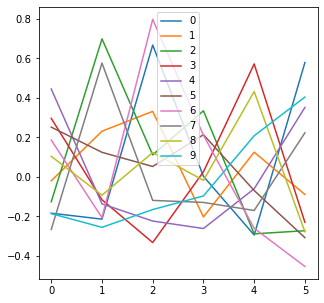

In [8]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

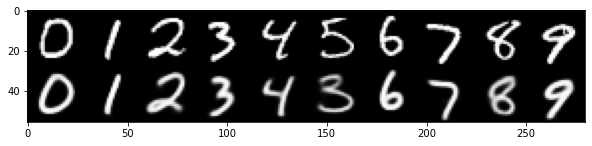

In [9]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [10]:
from XAE.sampler import gaus

exn = 5

In [11]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

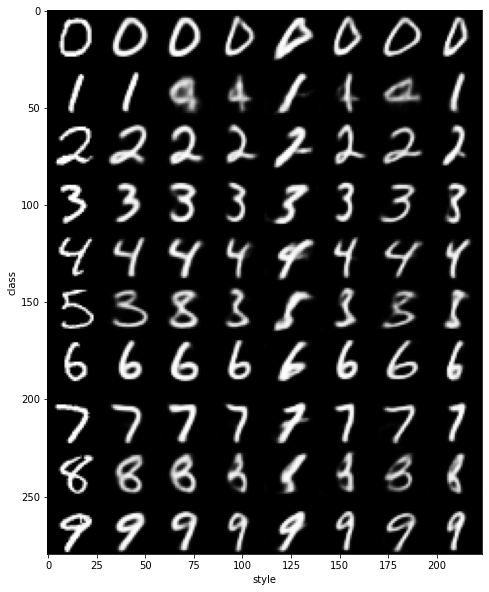

In [12]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [13]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

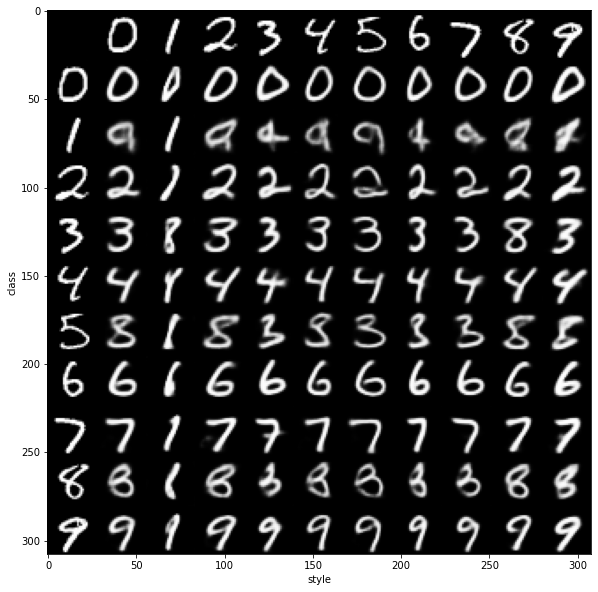

In [14]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()